# **Regression Model Training Notebook**



---
## 0. Setup Environment

### 0.b Disable Warnings Messages

> Do not modify this code before running it

In [32]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 0.c Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

### 0.d Import Packages

In [33]:

import pandas as pd
import altair as alt
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [34]:
from IPython.display import display, HTML

def print_tile(size="h3", key=None, value=None):
    """
    Display a styled HTML tile in a Jupyter notebook.
    Args:
        size (str): HTML heading size (e.g., 'h1', 'h2', 'h3').
        key (str): Optional label for the tile.
        value (str): The value or content to display.
    """
    if key is not None:
        html = f"<div style='margin:10px 0;'><{size} style='display:inline; color:#2a4d69; margin-right:10px;'>{key}:</{size}><span style='font-size:1.2em; color:#4b86b4;'>{value}</span></div>"
    else:
        html = f"<div style='margin:10px 0;'><{size} style='color:#2a4d69;'>{value}</{size}></div>"
    display(HTML(html))

---
## B. Business Understanding

In [35]:
 
business_use_case_description = """Develop a machine learning model to predict customer NPS categories—Promoter, Passive, and Detractor—based on available customer data.
 The model will focus on precisely identifying Promoters and Passives, helping to shape targeted engagement strategies that encourage Passives to become Promoters and strengthen customer loyalty.
 Accurately detect Detractors who are at high risk of churn, allowing the business to intervene early with retention strategies and prevent potential customer loss.
"""

In [36]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [37]:

business_objectives = """
#### Increase Customer Advocacy
Identify Promoters and leverage them for referral programs, brand loyalty initiatives, and word-of-mouth marketing.

#### Enhance Customer Retention
Detect Passive customers early and implement strategies to convert them into Promoters, strengthening long-term engagement.

#### Prevent Customer Churn
Accurately identify Detractors to trigger timely retention interventions and reduce the likelihood of customer loss.
"""


In [38]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [39]:
 
stakeholders_expectations_explanations = """

The model is expected to accurately predict Passive customers while maintaining an f1 score threshold below 80%, with a reliability margin of ±2%.
Additionally, it must identify Promoters with a recall rate of at least 80%, within a ±2% reliability margin, to support brand advocacy efforts.
Equally important, the model should effectively detect Detractors to enable timely churn prevention strategies with a f1 score of at least 80%, within a ±2% reliability margin,.

These expectations emphasize consistent performance, reduced misclassification risks, and the ability to generate actionable insights across all key customer segments—Promoters, Passives, and Detractors.

"""


In [40]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets

In [41]:
 
# Do not modify this code
try:
  df1 = pd.read_csv("../data/processed/df_eng_customer_address.csv")
except Exception as e:
  print(e)

In [42]:

# Do not modify this code
try:
  df2 = pd.read_csv("../data/processed/df_eng_customer_satisfaction.csv")
except Exception as e:
  print(e)

In [43]:

# Merge the two DataFrames on 'customer_id'
df = pd.merge(df1, df2, on='customer_id', how='inner')  # Use 'left', 'right', or 'outer' if needed
df.head()
df.columns


Index(['customer_id', 'street', 'type', 'suburb', 'postcode', 'full_address',
       'postcode_bin', 'state', 'neighborhood_density', 'nps', 'cltv',
       'reason', 'nps_category', 'avg_cltv_for_nps_category',
       'cltv_percentile_rank', 'cltv_quartile'],
      dtype='object')

### C.2 Define Target variable

In [44]:
 
target_definition_explanations = """ my classification model will classify  the following categories
- Promoters (NPS 4-5): Highly satisfied customers who actively recommend the brand.
- Passives (NPS 3): Neutral customers who are content but not enthusiastic.
- Detractors (NPS 1-2): Unhappy customers who may discourage others from using the service.

- Promoters drive growth, Passives are vulnerable to competitors, and Detractors pose churn risks.
- Understanding these groups helps businesses improve customer retention and satisfaction.
"""

In [45]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [46]:
 

target_name = 'nps_category'

### C.4 Explore Target variable

In [47]:
df.nps_category.head()

0     Passive
1     Passive
2     Passive
3    Promoter
4    Promoter
Name: nps_category, dtype: object

Lets check for imbalance of data

In [48]:
df.nps_category.value_counts()

nps_category
Promoter     2938
Passive      2665
Detractor    1440
Name: count, dtype: int64

NPS Category Distribution:
nps_category
Promoter     2938
Passive      2665
Detractor    1440
Name: count, dtype: int64


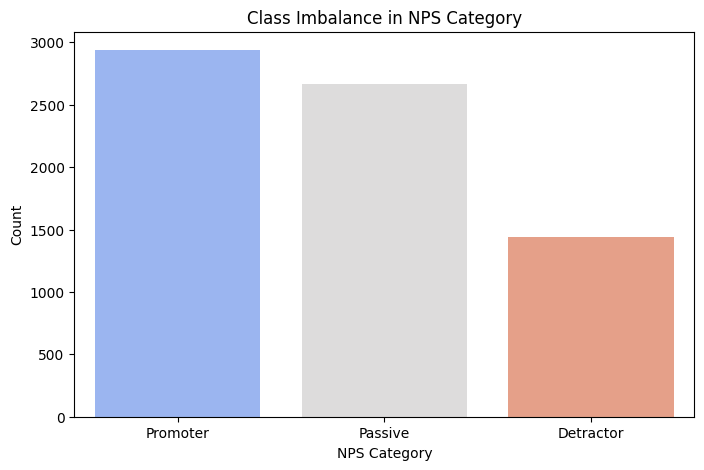

In [49]:


# Check the distribution of the target variable
category_counts = df['nps_category'].value_counts()

# Print counts for each category
print("NPS Category Distribution:")
print(category_counts)

# Visualize class imbalance
plt.figure(figsize=(8, 5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='coolwarm')
plt.xlabel("NPS Category")
plt.ylabel("Count")
plt.title("Class Imbalance in NPS Category")
plt.show()


The class looks imbalance. The Promoter category has the highest count, followed by Passives, and Detractors are the least represented. correctly classifying Detractors could be a challenge for the model. So we will deal with this later using SMOTE.

In [50]:
 
target_distribution_explanations = """
### Target Variable Definition:
The target variable, nps_category, consists of three distinct customer segments: Promoters, Passives, and Detractors.
This classification helps analyze customer satisfaction levels and predict engagement strategies.

### Data Distribution:
The dataset contains over 2,500 data points representing Promoters and Passives, making them the dominant segments.
Detractors are comparatively fewer, with around 1,400 data points, indicating a potential imbalanced dataset.

"""

In [51]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Feature of Interest 1 - State

> State-level analysis can assist in predicting demand trends based on location.
> Customers from different states may exhibit distinct purchasing behaviors due to regional preferences, economic conditions, or demographics.

In [52]:
df.state.value_counts()

state
TAS    765
VIC    746
WA     738
NT     733
ACT    715
QLD    707
NSW    702
SA     661
Name: count, dtype: int64

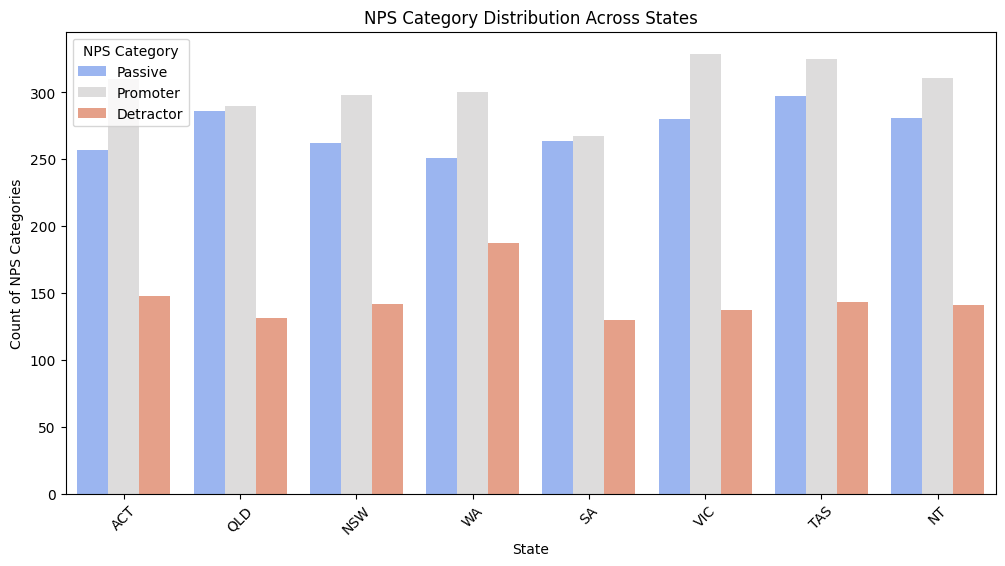

In [53]:


plt.figure(figsize=(12, 6))
sns.countplot(x='state', hue='nps_category', data=df, palette='coolwarm')
plt.xticks(rotation=45)
plt.xlabel("State")
plt.ylabel("Count of NPS Categories")
plt.title("NPS Category Distribution Across States")
plt.legend(title="NPS Category")
plt.show()


ACT, VIC, TAS, NT states have more Promoters vs Detractors.

SA state has consistently have lower average NPS scores.

WA state showing higher dissatisfaction trends.

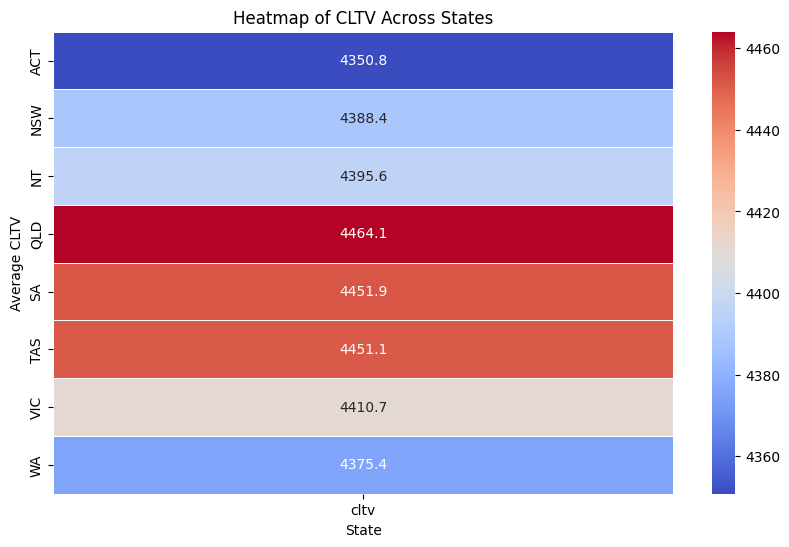

In [54]:
# Pivot the data to create a heatmap-friendly format
state_cltv_pivot = df.pivot_table(values='cltv', index='state', aggfunc='mean')

# Generate heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(state_cltv_pivot, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5)
plt.xlabel("State")
plt.ylabel("Average CLTV")
plt.title("Heatmap of CLTV Across States")
plt.show()


Key Insights
QLD states have the highest CLTV (Valuable customer regions)

certain states like WA, ACT, VIC show lower CLTV values? (Potential churn hotspots)



In [55]:
 
feature1_insights = """

### State-Level NPS Trends
ACT, VIC, TAS, and NT have a higher ratio of Promoters compared to Detractors, indicating strong customer satisfaction in these regions.
SA consistently records lower average NPS scores, suggesting ongoing concerns or gaps in customer experience.
WA shows a noticeable trend of customer dissatisfaction, highlighting a potential need for service improvements.

### Customer Lifetime Value (CLTV) Insights
QLD stands out as the most valuable customer region, boasting the highest CLTV among all states.
Conversely, WA, ACT, and VIC show lower CLTV values, signaling potential churn risks that require intervention.

"""

In [56]:
# Do not modify this code
print_tile(size="h3", key='feature1_insights', value=feature1_insights)

### C.6 Explore Feature of Interest 2

> reason

Customer’s specific reason for leaving the company

Impact of Dissatisfaction Reasons on NPS

In [57]:
# Count unique reasons and their occurrences
reason_counts = df['reason'].value_counts()
print(reason_counts)


reason
Competitor had better devices                313
Competitor made better offer                 311
Attitude of support person                   220
Don't know                                   130
Competitor offered more data                 117
Competitor offered higher download speeds    100
Attitude of service provider                  94
Price too high                                78
Product dissatisfaction                       77
Network reliability                           72
Long distance charges                         64
Service dissatisfaction                       63
Moved                                         46
Extra data charges                            39
Limited range of services                     37
Poor expertise of online support              31
Lack of affordable download/upload speed      30
Lack of self-service on Website               29
Poor expertise of phone support               12
Deceased                                       6
Name: count, 

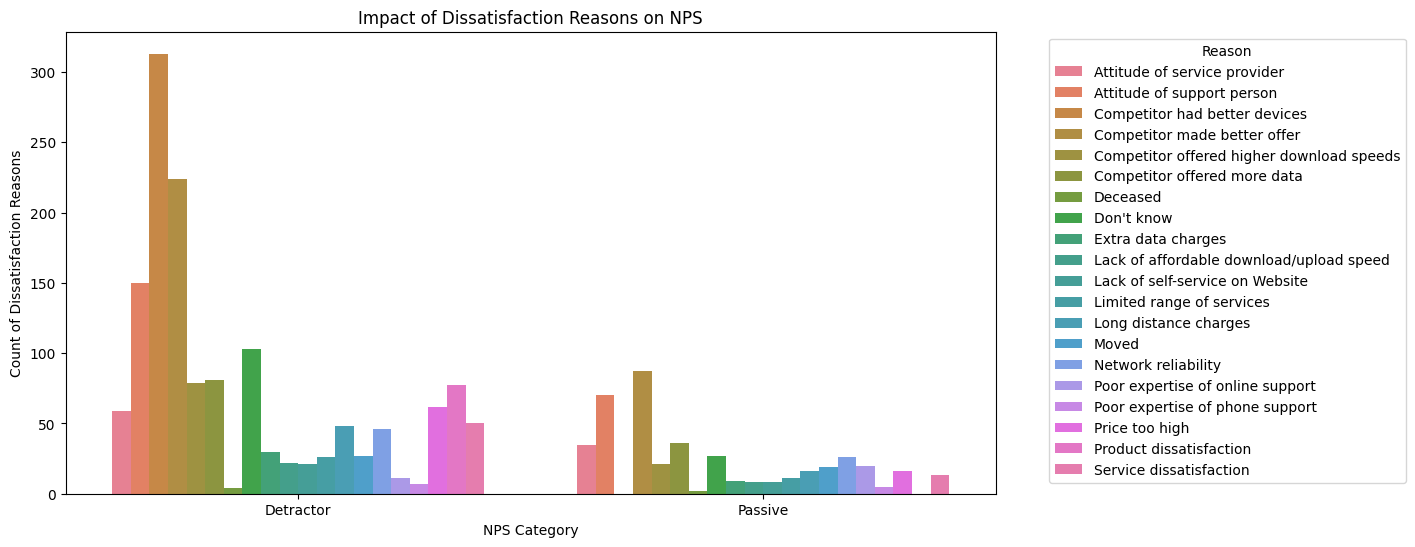

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count occurrences of dissatisfaction reasons across NPS categories
reason_nps_relation = df.groupby(['nps_category', 'reason']).size().reset_index(name='count')

# Visualize dissatisfaction reasons by NPS category
plt.figure(figsize=(12, 6))
sns.barplot(x='nps_category', y='count', hue='reason', data=reason_nps_relation)
plt.xlabel("NPS Category")
plt.ylabel("Count of Dissatisfaction Reasons")
plt.title("Impact of Dissatisfaction Reasons on NPS")
plt.legend(title="Reason", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Attitude of support person, competitors had better devices are some of the reasons that are most common among Detractors.

This helps identify trends in customer dissatisfaction.

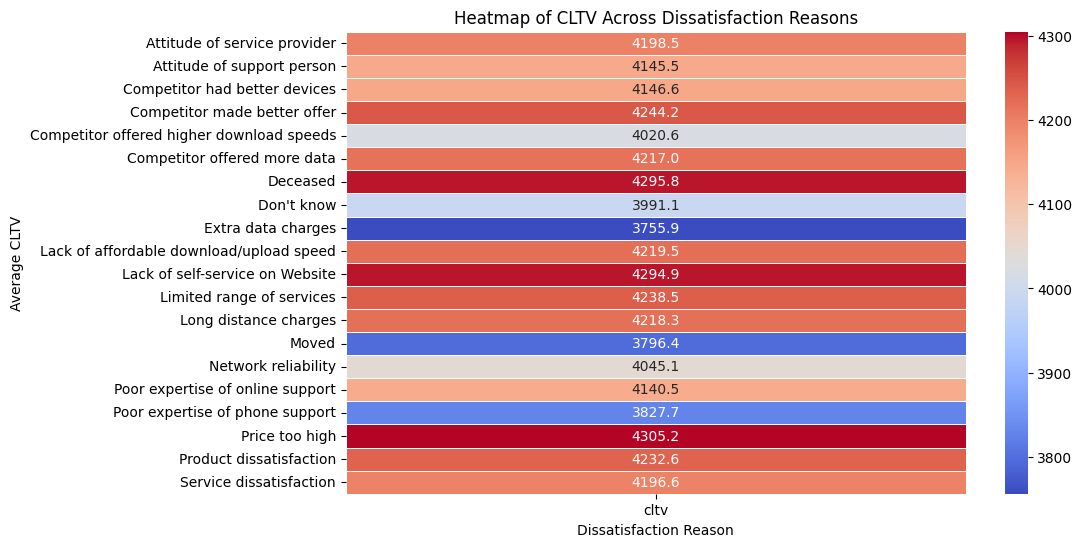

In [59]:
import pandas as pd

# Pivot table for heatmap
reason_cltv_pivot = df.pivot_table(values='cltv', index='reason', aggfunc='mean')

# Generate heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(reason_cltv_pivot, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5)
plt.xlabel("Dissatisfaction Reason")
plt.ylabel("Average CLTV")
plt.title("Heatmap of CLTV Across Dissatisfaction Reasons")
plt.show()


extra data charges,moved, poor expertise of phone support are the few reasons correlate with lower CLTV. so the bussiness needs to focus on these problems.

In [60]:
 
feature_2_insights = """

### Common Reasons for Detractors
Attitude of support personnel and competitor offerings with better devices are among the most frequently cited reasons for dissatisfaction.
These trends indicate that service quality and competitive product features significantly influence customer sentiment.

### Factors Correlating with Lower CLTV
Issues such as extra data charges, relocation, and poor expertise in phone support are strongly linked to lower Customer Lifetime Value (CLTV).
Addressing these concerns proactively can enhance customer retention and improve overall revenue potential.

"""

In [61]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.6 Explore Feature of Interest n

> You can add more cells in this section

In [62]:
 
feature_n_insights = """
"""

In [63]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)

---
## D. Feature Selection


In [64]:
 

features_list = df.columns.tolist()
features_list

['customer_id',
 'street',
 'type',
 'suburb',
 'postcode',
 'full_address',
 'postcode_bin',
 'state',
 'neighborhood_density',
 'nps',
 'cltv',
 'reason',
 'nps_category',
 'avg_cltv_for_nps_category',
 'cltv_percentile_rank',
 'cltv_quartile']

Checking for Feature Variability in order to remove columns with low variance, as they might not provide useful information.

In [65]:
non_numerical_df = df.select_dtypes(exclude=['number'])
non_numerical_df

,customer_id,street,type,suburb,full_address,state,reason,nps_category,cltv_quartile
0,d36b3782-86b2-4f7e-97f4-19751cf735b1,Chandler Gardens,Park,Smithchester,"Suite 159 4 Chandler Gardens Park, Smithcheste...",ACT,NaN,Passive,Q1
1,c16a23a6-c001-4846-b16a-e681692d861b,Tara Alleyway,Avenue,Mayberg,"Flat 31 247 Tara Alleyway Avenue, Mayberg QLD...",QLD,NaN,Passive,Q3
2,f044a91f-3eeb-4342-9c96-2be28927a8a9,Sullivan Reserve,Reach,Vegamouth,"Level 5 591 Sullivan Reserve Reach, Vegamouth ...",QLD,NaN,Passive,Q3
3,36096d1a-4f30-4c1c-8453-3db3ea81692c,Daniel Parade,Break,East Matthewfurt,"Unit 09 7 Daniel Parade Break, East Matthewfur...",NSW,NaN,Promoter,Q3
4,7484593e-4ff2-44d6-9de6-7e3bd9fe8b19,Charles Driveway,River,New Shannon,"720/460 Charles Driveway River, New Shannon W...",WA,NaN,Promoter,Q3
...,...,...,...,...,...,...,...,...,...
7038,785cf394-06ef-4eae-9772-26cef4d4fb40,Monica Triangle,Grange,East Josephhaven,"Level 0 6 Monica Triangle Grange, East Josephh...",NSW,NaN,Promoter,Q4
7039,668dd5e8-8149-4dd7-bed3-574554a742c2,Peter Riviera,Glen,New Keithmouth,"91/5 Peter Riviera Glen, New Keithmouth WA, ...",WA,Attitude of support person,Detractor,Q2
7040,98f94553-e5c9-4732-87ad-0aa7f99ec659,Powers Mount,Path,Garciaton,"Apt. 882 134 Powers Mount Path, Garciaton QLD...",QLD,NaN,Passive,Q1
7041,117eddb6-5868-4bd2-a7a5-e1588055e0b4,Gomez Port,Path,Adamsburgh,"Flat 44 13 Gomez Port Path, Adamsburgh NT, 0935",NT,Competitor made better offer,Detractor,Q1


In [66]:
#encoding categorical features or feature importnace selection
encodable_features=['state','street','type','suburb','reason','nps_category','cltv_quartile']
original_df=df.copy()

# Initialize LabelEncoder
label_encoders = {}

# Apply Label Encoding to each feature
for feature in encodable_features:
    label_encoders[feature] = LabelEncoder()
    df[feature] = label_encoders[feature].fit_transform(df[feature])

print("Label Encoding Applied!")

Label Encoding Applied!


In [67]:
non_numerical_df = df.select_dtypes(exclude=['number'])
non_numerical_df

,customer_id,full_address
0,d36b3782-86b2-4f7e-97f4-19751cf735b1,"Suite 159 4 Chandler Gardens Park, Smithcheste..."
1,c16a23a6-c001-4846-b16a-e681692d861b,"Flat 31 247 Tara Alleyway Avenue, Mayberg QLD..."
2,f044a91f-3eeb-4342-9c96-2be28927a8a9,"Level 5 591 Sullivan Reserve Reach, Vegamouth ..."
3,36096d1a-4f30-4c1c-8453-3db3ea81692c,"Unit 09 7 Daniel Parade Break, East Matthewfur..."
4,7484593e-4ff2-44d6-9de6-7e3bd9fe8b19,"720/460 Charles Driveway River, New Shannon W..."
...,...,...
7038,785cf394-06ef-4eae-9772-26cef4d4fb40,"Level 0 6 Monica Triangle Grange, East Josephh..."
7039,668dd5e8-8149-4dd7-bed3-574554a742c2,"91/5 Peter Riviera Glen, New Keithmouth WA, ..."
7040,98f94553-e5c9-4732-87ad-0aa7f99ec659,"Apt. 882 134 Powers Mount Path, Garciaton QLD..."
7041,117eddb6-5868-4bd2-a7a5-e1588055e0b4,"Flat 44 13 Gomez Port Path, Adamsburgh NT, 0935"


dropping theset two columns as they donont provide any information to the model

In [68]:
df.head()

,customer_id,street,type,suburb,postcode,full_address,postcode_bin,state,neighborhood_density,nps,cltv,reason,nps_category,avg_cltv_for_nps_category,cltv_percentile_rank,cltv_quartile
0,d36b3782-86b2-4f7e-97f4-19751cf735b1,989,114,4383,6683.0,"Suite 159 4 Chandler Gardens Park, Smithcheste...",6.0,0,1.0,3,2997,20,1,4473.402627,0.167258,0
1,c16a23a6-c001-4846-b16a-e681692d861b,6032,8,2567,2629.0,"Flat 31 247 Tara Alleyway Avenue, Mayberg QLD...",2.0,3,17.0,3,4867,20,1,4473.402627,0.596124,2
2,f044a91f-3eeb-4342-9c96-2be28927a8a9,5975,137,5332,2790.0,"Level 5 591 Sullivan Reserve Reach, Vegamouth ...",2.0,3,4.0,3,4676,20,1,4473.402627,0.543660,2
3,36096d1a-4f30-4c1c-8453-3db3ea81692c,1374,16,1051,2839.0,"Unit 09 7 Daniel Parade Break, East Matthewfur...",2.0,1,3.0,5,4791,20,2,4462.120830,0.574329,2
4,7484593e-4ff2-44d6-9de6-7e3bd9fe8b19,1004,147,3079,2611.0,"720/460 Charles Driveway River, New Shannon W...",2.0,7,23.0,4,4673,20,2,4462.120830,0.542950,2


In [69]:
features_list = list(set(features_list) - {'customer_id', 'full_address'})


In [70]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

In [71]:


# Calculate variance for numerical features
feature_variance = numerical_df.var()

# Identify low-variance features (threshold can be adjusted)
low_variance_features = feature_variance[feature_variance < 0.01].index
print("Low Variance Features:", low_variance_features.tolist())


# Drop low-variance features (if necessary)
df_filtered = numerical_df.drop(columns=low_variance_features)


Low Variance Features: []


NO feature has low variance hence all featurs add value to the model.

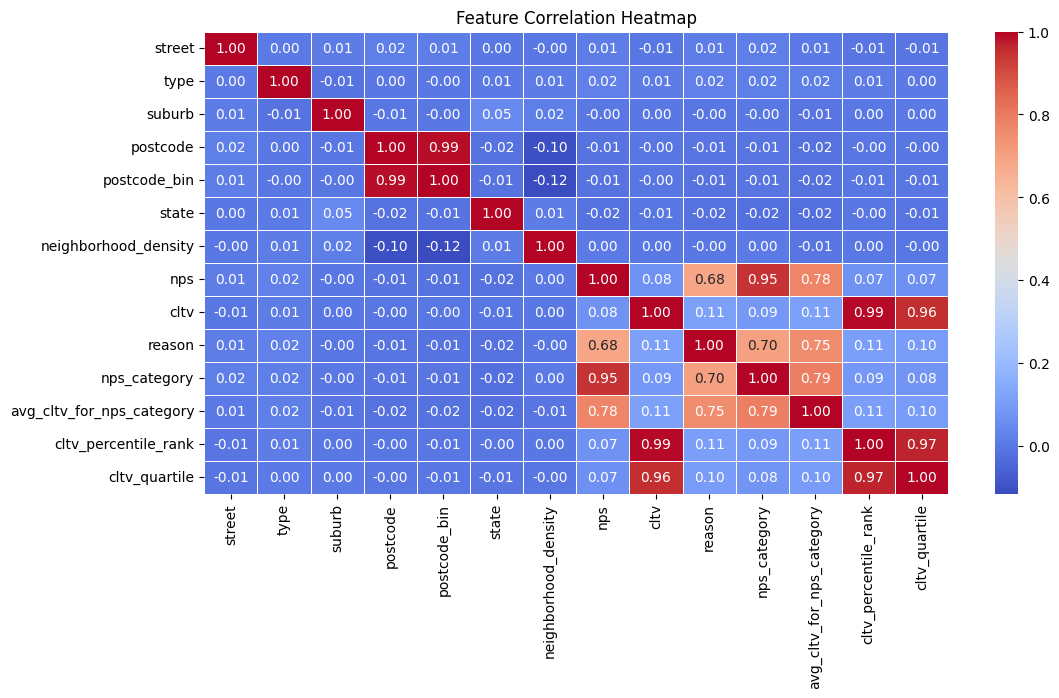

In [72]:


# Compute correlation matrix
correlation_matrix = df_filtered.corr()

# Visualize correlation with a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


- we can drop postcode_bin,cltv_quartile and cltv_percentile_rank as they donont add more value to the model training as they are highly correlated to other columns.
- nps_category is derived from nps column and avg_cltv_for_nps_category columns is derived from nps_category hence we should drop that column as well since it can cause data leakage. (the model learns from information that shouldn't be available during prediction.)


In [73]:
# Using set difference
features_list = list(set(features_list) - {'postcode_bin', 'cltv_percentile_rank','nps','avg_cltv_for_nps_category','cltv_quartile'})

features_list

['postcode',
 'nps_category',
 'neighborhood_density',
 'cltv',
 'reason',
 'street',
 'state',
 'suburb',
 'type']

Using Feature Importance with Tree-Based Models

                      Feature  Importance
7                         nps    0.458722
10  avg_cltv_for_nps_category    0.379891
9                      reason    0.151068
8                        cltv    0.002435
11       cltv_percentile_rank    0.002238
3                    postcode    0.001215
0                      street    0.001002
2                      suburb    0.000968
1                        type    0.000831
6        neighborhood_density    0.000534
12              cltv_quartile    0.000479
5                       state    0.000376
4                postcode_bin    0.000241


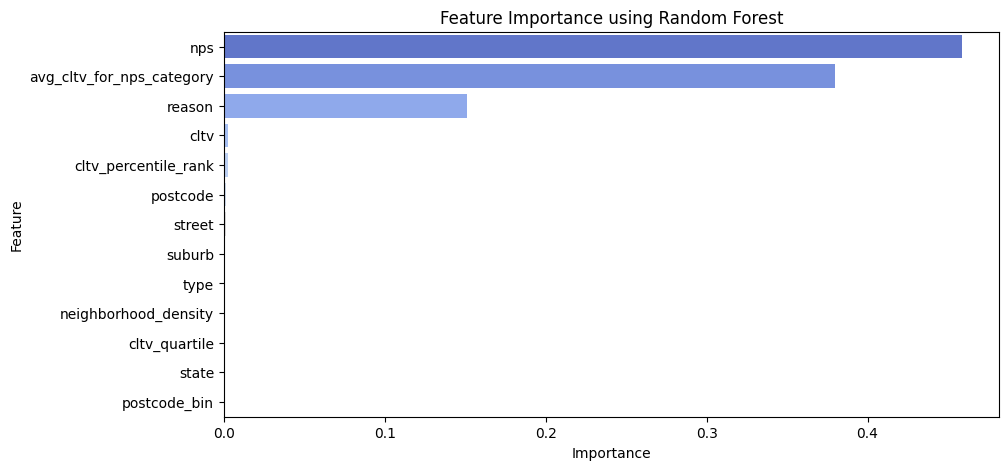

In [74]:


# Define features and target
X = df_filtered.drop(columns=['nps_category'])  # Assuming 'nps_category' is the target
y = df_filtered['nps_category']

# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='coolwarm')
plt.title("Feature Importance using Random Forest")
plt.show()


important columns- avg_citv_for_nps_category and reason column for training purposes.

In [75]:
df=original_df.copy()


In [76]:
 
feature_selection_insights = """

1. **Categorical Feature Encoding**
   - Converted **categorical features into numerical values** using **Label Encoding** to facilitate operations like correlation analysis and predictive modeling.

2. **Dropping Non-Contributory Columns**
   - **Removed `customer_id`**, as it contains **unique values that do not contribute to model training**.
   - **Eliminated `full_address`**, since all relevant location details were **extracted into separate columns**, making it redundant.

3. **Handling Highly Correlated Features**
   - **Dropped `postcode_bin`, `cltv_quartile`, and `cltv_percentile_rank`** as they were **highly correlated with other features**, adding no extra value to model performance.
   - **Eliminated `nps_category` and `avg_cltv_for_nps_category`**, since `nps_category` is derived from `nps`, and `avg_cltv_for_nps_category` is further derived from `nps_category`.
   - Keeping these columns could **lead to data leakage**, meaning the model would learn from information that shouldn’t be available during prediction.

4. **Feature Selection for Model Training**
   - Applied **feature selection techniques** to identify the **most relevant features** that contribute **effectively to model accuracy and reliability**.
   - Ensured that **only meaningful variables** are retained, improving prediction efficiency and reducing computational complexity.


"""

In [77]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_insights', value=feature_selection_insights)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

## LABEL ENCODING
Improves Model Performance → Standardizing, normalizing, and encoding data enhances the model's ability to learn patterns effectively.

Handles Missing & Inconsistent Data → Transformation techniques ensure a cleaner dataset by filling gaps or removing redundant information.

In [78]:
df.head()

,customer_id,street,type,suburb,postcode,full_address,postcode_bin,state,neighborhood_density,nps,cltv,reason,nps_category,avg_cltv_for_nps_category,cltv_percentile_rank,cltv_quartile
0,d36b3782-86b2-4f7e-97f4-19751cf735b1,Chandler Gardens,Park,Smithchester,6683.0,"Suite 159 4 Chandler Gardens Park, Smithcheste...",6.0,ACT,1.0,3,2997,NaN,Passive,4473.402627,0.167258,Q1
1,c16a23a6-c001-4846-b16a-e681692d861b,Tara Alleyway,Avenue,Mayberg,2629.0,"Flat 31 247 Tara Alleyway Avenue, Mayberg QLD...",2.0,QLD,17.0,3,4867,NaN,Passive,4473.402627,0.596124,Q3
2,f044a91f-3eeb-4342-9c96-2be28927a8a9,Sullivan Reserve,Reach,Vegamouth,2790.0,"Level 5 591 Sullivan Reserve Reach, Vegamouth ...",2.0,QLD,4.0,3,4676,NaN,Passive,4473.402627,0.543660,Q3
3,36096d1a-4f30-4c1c-8453-3db3ea81692c,Daniel Parade,Break,East Matthewfurt,2839.0,"Unit 09 7 Daniel Parade Break, East Matthewfur...",2.0,NSW,3.0,5,4791,NaN,Promoter,4462.120830,0.574329,Q3
4,7484593e-4ff2-44d6-9de6-7e3bd9fe8b19,Charles Driveway,River,New Shannon,2611.0,"720/460 Charles Driveway River, New Shannon W...",2.0,WA,23.0,4,4673,NaN,Promoter,4462.120830,0.542950,Q3


In [79]:
#encoding categorical features or feature importnace selection
encodable_features=['state','street','type','suburb','reason','nps_category','cltv_quartile']


# Initialize LabelEncoder
label_encoders = {}

# Apply Label Encoding to each feature
for feature in encodable_features:
    label_encoders[feature] = LabelEncoder()
    df[feature] = label_encoders[feature].fit_transform(df[feature])

print("Label Encoding Applied!")

Label Encoding Applied!


In [80]:
df.head()

,customer_id,street,type,suburb,postcode,full_address,postcode_bin,state,neighborhood_density,nps,cltv,reason,nps_category,avg_cltv_for_nps_category,cltv_percentile_rank,cltv_quartile
0,d36b3782-86b2-4f7e-97f4-19751cf735b1,989,114,4383,6683.0,"Suite 159 4 Chandler Gardens Park, Smithcheste...",6.0,0,1.0,3,2997,20,1,4473.402627,0.167258,0
1,c16a23a6-c001-4846-b16a-e681692d861b,6032,8,2567,2629.0,"Flat 31 247 Tara Alleyway Avenue, Mayberg QLD...",2.0,3,17.0,3,4867,20,1,4473.402627,0.596124,2
2,f044a91f-3eeb-4342-9c96-2be28927a8a9,5975,137,5332,2790.0,"Level 5 591 Sullivan Reserve Reach, Vegamouth ...",2.0,3,4.0,3,4676,20,1,4473.402627,0.543660,2
3,36096d1a-4f30-4c1c-8453-3db3ea81692c,1374,16,1051,2839.0,"Unit 09 7 Daniel Parade Break, East Matthewfur...",2.0,1,3.0,5,4791,20,2,4462.120830,0.574329,2
4,7484593e-4ff2-44d6-9de6-7e3bd9fe8b19,1004,147,3079,2611.0,"720/460 Charles Driveway River, New Shannon W...",2.0,7,23.0,4,4673,20,2,4462.120830,0.542950,2


In [81]:
 
data_cleaning_1_explanations = """

we label encoded the columns such as ['state','street','type','suburb','reason','nps_category','cltv_quartile'] so that they can contribut to the model training.
and to remove the redundant information.
"""

In [82]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation <put_name_here>
### Transforming postcode column
>making the postcode column suitable to train during model training .


In [83]:
df.shape

(7043, 16)

In [84]:
df.isnull().sum()

customer_id                     0
street                          0
type                            0
suburb                          0
postcode                      436
full_address                 1276
postcode_bin                  436
state                           0
neighborhood_density          436
nps                             0
cltv                            0
reason                          0
nps_category                    0
avg_cltv_for_nps_category       0
cltv_percentile_rank            0
cltv_quartile                   0
dtype: int64

Since we are gonna use postcode column during training so we will drop na values and we donont care about other null values as those columns are not being used in modeling.

In [85]:
df.dropna(subset=['postcode'],inplace=True)


In [86]:
df.isnull().sum()

customer_id                    0
street                         0
type                           0
suburb                         0
postcode                       0
full_address                 840
postcode_bin                   0
state                          0
neighborhood_density           0
nps                            0
cltv                           0
reason                         0
nps_category                   0
avg_cltv_for_nps_category      0
cltv_percentile_rank           0
cltv_quartile                  0
dtype: int64

In [87]:
 
data_cleaning_2_explanations = """

We found **436 missing values** in the `postcode` column and removed them to prevent inconsistencies, ensuring better model accuracy.


"""

In [88]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Data Transformation <put_name_here>

> Provide some explanations on why you believe it is important to perform this data transformation and its impacts


In [89]:
 
data_cleaning_3_explanations = """
"""

In [90]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

---
## F. Feature Engineering

### F.1 New Feature "Urban_Flag"

> Helps differentiate customer behavior based on population density.


In [91]:
df.columns

Index(['customer_id', 'street', 'type', 'suburb', 'postcode', 'full_address',
       'postcode_bin', 'state', 'neighborhood_density', 'nps', 'cltv',
       'reason', 'nps_category', 'avg_cltv_for_nps_category',
       'cltv_percentile_rank', 'cltv_quartile'],
      dtype='object')

In [92]:
df['urban_flag'] = df['neighborhood_density'].apply(lambda x: 1 if x > df['neighborhood_density'].median() else 0)


In [93]:
df.urban_flag.head()

0    0
1    1
2    0
3    0
4    1
Name: urban_flag, dtype: int64

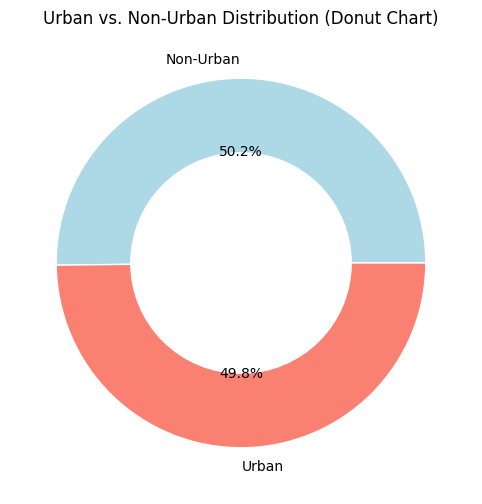

In [94]:
import matplotlib.pyplot as plt

# Count occurrences of urban_flag values
urban_counts = df['urban_flag'].value_counts()

# Define colors
colors = ["lightblue", "salmon"]

# Create pie chart (donut style)
plt.figure(figsize=(8, 6))
plt.pie(urban_counts, labels=["Non-Urban", "Urban"], autopct="%1.1f%%", colors=colors, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# Add circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Urban vs. Non-Urban Distribution (Donut Chart)")
plt.show()


In [95]:
 
feature_engineering_1_explanations = """

We created a new column, Urban Flag, based on neighborhood density, classifying areas as urban or non-urban.
To visualize the distribution, we plotted a donut chart, revealing that 50.2% of data points belong to non-urban areas, while 49.8% fall into urban regions.
This near-even split suggests a balanced representation between urban and non-urban customers, which could impact location-based customer engagement strategies and predictive modeling outcomes.

"""

In [96]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature "cltv_segment"

Categorized customers into Low, Medium, and High-value groups.

Helps analyze spending behaviors, engagement trends, and loyalty levels.

Supports targeted strategies for customer retention and revenue optimization.

Improves predictive modeling by incorporating customer value classifications.


In [97]:
df['cltv_segment'] = pd.qcut(df['cltv'], q=3, labels=['Low', 'Medium', 'High'])


In [98]:
df.cltv_segment.head()

0       Low
1    Medium
2    Medium
3    Medium
4    Medium
Name: cltv_segment, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

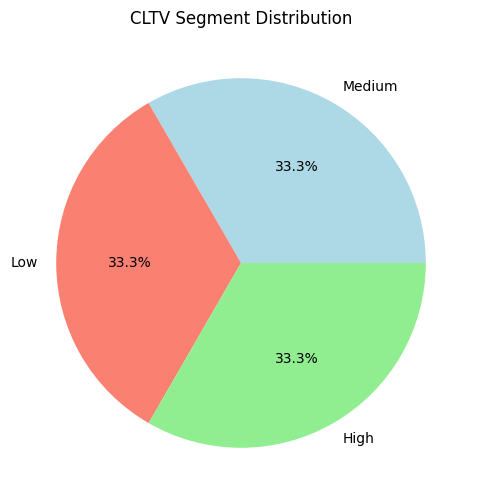

In [99]:
# Count occurrences of CLTV segments
cltv_counts = df['cltv_segment'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(cltv_counts, labels=cltv_counts.index, autopct="%1.1f%%", colors=["lightblue", "salmon", "lightgreen"])
plt.title("CLTV Segment Distribution")
plt.show()


In [100]:
 
feature_engineering_2_explanations = """

The three CLTV segment categories—Low, Medium, and High—are evenly distributed in the dataset.
This balanced segmentation ensures that the model can effectively learn patterns across all customer groups, leading to fair predictions and improved strategy development for targeted customer engagement.

"""

In [101]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature "postcode_repeat_count"

Helps identify customer density within specific locations.

Useful for geographic segmentation and understanding regional customer distribution.

Can highlight potential high-churn areas based on postcode concentration.



lets Identifies customers in highly clustered areas.

In [102]:
df['postcode_repeat_count'] = df.groupby('postcode')['customer_id'].transform('count')


In [103]:
df.postcode_repeat_count.head()

0     1
1    16
2     4
3     3
4    19
Name: postcode_repeat_count, dtype: int64

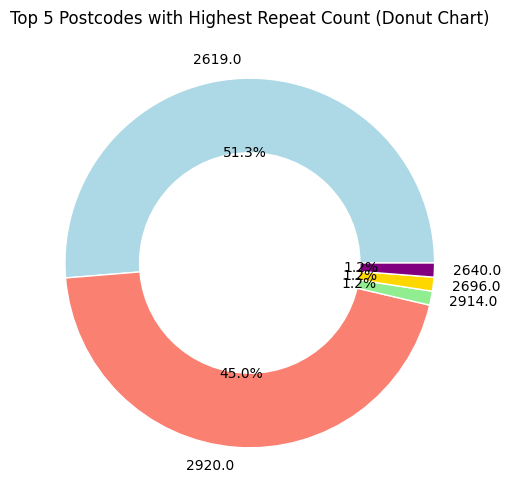

In [104]:


# Aggregate total repeat count per postcode
postcode_repeat_counts = df.groupby('postcode')['postcode_repeat_count'].sum().reset_index()

# Sort by total repeat count in descending order and select top 5
top_5_postcodes = postcode_repeat_counts.sort_values(by='postcode_repeat_count', ascending=False).head(5)

# Define colors
colors = ["lightblue", "salmon", "lightgreen", "gold", "purple"]

# Create pie chart (donut style)
plt.figure(figsize=(8, 6))
plt.pie(top_5_postcodes['postcode_repeat_count'], labels=top_5_postcodes['postcode'], autopct="%1.1f%%", colors=colors, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# Add circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Top 5 Postcodes with Highest Repeat Count (Donut Chart)")
plt.show()


In [105]:
# Define the new features
new_features = ['postcode_repeat_count', 'cltv_segment', 'urban_flag']

# Add them to features_list
features_list.extend(new_features)

# Verify the updated list
print("Updated Features List:", features_list)


Updated Features List: ['postcode', 'nps_category', 'neighborhood_density', 'cltv', 'reason', 'street', 'state', 'suburb', 'type', 'postcode_repeat_count', 'cltv_segment', 'urban_flag']


In [106]:
 
feature_engineering_3_explanations = """
It is observed that 51.3% of entries belong to postcode 2619, while 45% are associated with postcode 2920 among the top five postcodes.
This indicates a high customer density in these regions, which could be useful for geographic-based marketing strategies and localized customer engagement efforts.
Understanding these concentrated areas can help businesses tailor services and optimize their approach to regional demand.
and then we added the new feature to the final list of features

"""

In [107]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_3_explanations', value=feature_engineering_3_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

> Provide some explanations on what is the best strategy to use for data splitting for this dataset


In [108]:
# Sort the DataFrame by 'current_semester' in ascending order
df_sorted = df.copy()

# Calculate split indices for train (70%), validation (15%), and test (15%)
train_size = int(0.7 * len(df_sorted))
val_size = int(0.15 * len(df_sorted))
test_size = len(df_sorted) - train_size - val_size

# Split the data
train_df = df_sorted.iloc[:train_size]  # First 70%
validation_df = df_sorted.iloc[train_size:train_size + val_size]  # Next 15%
test_df = df_sorted.iloc[train_size + val_size:]  # Remaining 15%

# Print sizes of each split
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 4624
Validation set size: 991
Test set size: 992


- The data is divided into 70% train, 15% validation, and 15% test to maintain standard proportions.
-  Training the model on earlier semesters and testing it on later semesters mimics a real-world application, where past data is used to predict future outcomes.
- This could apply to forecasting student performance for upcoming semesters or analyzing trends in academic improvement.
- model is trained on data reflecting historical patterns and tested on unseen future data

In [109]:
 
data_splitting_explanations = """

- The data is divided into 70% train, 15% validation, and 15% test to maintain standard proportions.
-  Training the model on earlier semesters and testing it on later semesters mimics a real-world application, where past data is used to predict future outcomes.
- This could apply to forecasting student performance for upcoming semesters or analyzing trends in academic improvement.
- model is trained on data reflecting historical patterns and tested on unseen future data

"""

In [110]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "Converting categorical feauture into numerical feature"

Enhances Predictive Accuracy → Allows models to identify meaningful patterns within categorical variables.

Facilitates Feature Comparisons → Enables correlation analysis and statistical evaluations.

Improves Computational Efficiency → Reduces processing complexity, making training more efficient.


In [111]:
train_df.cltv_segment.head()


0       Low
1    Medium
2    Medium
3    Medium
4    Medium
Name: cltv_segment, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

In [112]:
label_encoder = LabelEncoder()
train_df['cltv_segment'] = label_encoder.fit_transform(train_df['cltv_segment'])
test_df['cltv_segment'] = label_encoder.transform(test_df['cltv_segment'])
validation_df['cltv_segment'] = label_encoder.transform(validation_df['cltv_segment'])



C:\Users\agama\AppData\Local\Temp\ipykernel_1576\2537111286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cltv_segment'] = label_encoder.fit_transform(train_df['cltv_segment'])
C:\Users\agama\AppData\Local\Temp\ipykernel_1576\2537111286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cltv_segment'] = label_encoder.transform(test_df['cltv_segment'])
C:\Users\agama\AppData\Local\Temp\ipykernel_1576\2537111286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [113]:
train_df.cltv_segment.head()

0    1
1    2
2    2
3    2
4    2
Name: cltv_segment, dtype: int64

In [114]:
 
data_transformation_1_explanations = """

Converted CLTV Segment into a numerical feature for better model integration.

Helps analyze customer value patterns effectively.

Improves predictive accuracy and correlation studies.

Ensures seamless inclusion in statistical evaluations.

"""

In [115]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

### G.3 Data Transformation "Scaling"

Scaling ensures that numerical features are transformed to a standard range, promoting consistency in the dataset. This allows models to learn efficiently and prevents biases toward higher-value features. Additionally, scaling is essential when experimenting with linear-based models

In [116]:
train_df.head()

,customer_id,street,type,suburb,postcode,full_address,postcode_bin,state,neighborhood_density,nps,cltv,reason,nps_category,avg_cltv_for_nps_category,cltv_percentile_rank,cltv_quartile,urban_flag,cltv_segment,postcode_repeat_count
0,d36b3782-86b2-4f7e-97f4-19751cf735b1,989,114,4383,6683.0,"Suite 159 4 Chandler Gardens Park, Smithcheste...",6.0,0,1.0,3,2997,20,1,4473.402627,0.167258,0,0,1,1
1,c16a23a6-c001-4846-b16a-e681692d861b,6032,8,2567,2629.0,"Flat 31 247 Tara Alleyway Avenue, Mayberg QLD...",2.0,3,17.0,3,4867,20,1,4473.402627,0.596124,2,1,2,16
2,f044a91f-3eeb-4342-9c96-2be28927a8a9,5975,137,5332,2790.0,"Level 5 591 Sullivan Reserve Reach, Vegamouth ...",2.0,3,4.0,3,4676,20,1,4473.402627,0.543660,2,0,2,4
3,36096d1a-4f30-4c1c-8453-3db3ea81692c,1374,16,1051,2839.0,"Unit 09 7 Daniel Parade Break, East Matthewfur...",2.0,1,3.0,5,4791,20,2,4462.120830,0.574329,2,0,2,3
4,7484593e-4ff2-44d6-9de6-7e3bd9fe8b19,1004,147,3079,2611.0,"720/460 Charles Driveway River, New Shannon W...",2.0,7,23.0,4,4673,20,2,4462.120830,0.542950,2,1,2,19


In [117]:
from sklearn.preprocessing import StandardScaler

# Make a copy of the dataset
train_df_scaled = train_df.copy()

# Remove target variable before selecting numerical columns
target = train_df_scaled.pop('nps_category')

# Select only numerical columns
numerical_columns = train_df_scaled.select_dtypes(include=['number']).columns

# Initialize StandardScaler
scaler = StandardScaler()

# Apply scaling to numerical features
train_df_scaled[numerical_columns] = scaler.fit_transform(train_df_scaled[numerical_columns])

# Add target column back after scaling
train_df_scaled['nps_category'] = target

print("Numerical features scaled using StandardScaler!")
print(train_df_scaled.head())

# Overwrite train_df with the scaled version
train_df = train_df_scaled.copy()


Numerical features scaled using StandardScaler!
                            customer_id    street      type    suburb  \
0  d36b3782-86b2-4f7e-97f4-19751cf735b1 -1.225234  0.235547  0.808782   
1  c16a23a6-c001-4846-b16a-e681692d861b  1.361333 -1.605791 -0.250042   
2  f044a91f-3eeb-4342-9c96-2be28927a8a9  1.332097  0.635083  1.362099   
3  36096d1a-4f30-4c1c-8453-3db3ea81692c -1.027767 -1.466822 -1.133950   
4  7484593e-4ff2-44d6-9de6-7e3bd9fe8b19 -1.217541  0.808794  0.048481   

   postcode                                       full_address  postcode_bin  \
0  1.910550  Suite 159 4 Chandler Gardens Park, Smithcheste...      1.870706   
1 -0.301218  Flat 31 247 Tara Alleyway Avenue, Mayberg  QLD...     -0.248259   
2 -0.213380  Level 5 591 Sullivan Reserve Reach, Vegamouth ...     -0.248259   
3 -0.186647  Unit 09 7 Daniel Parade Break, East Matthewfur...     -0.248259   
4 -0.311038  720/460 Charles Driveway River, New Shannon  W...     -0.248259   

      state  neighborhood_densit

In [118]:
train_df.head()

,customer_id,street,type,suburb,postcode,full_address,postcode_bin,state,neighborhood_density,nps,cltv,reason,avg_cltv_for_nps_category,cltv_percentile_rank,cltv_quartile,urban_flag,cltv_segment,postcode_repeat_count,nps_category
0,d36b3782-86b2-4f7e-97f4-19751cf735b1,-1.225234,0.235547,0.808782,1.910550,"Suite 159 4 Chandler Gardens Park, Smithcheste...",1.870706,-1.571023,-0.466367,-0.208092,-1.190248,0.540935,0.553023,-1.152966,-1.337793,-0.983697,0.003452,-0.467412,1
1,c16a23a6-c001-4846-b16a-e681692d861b,1.361333,-1.605791,-0.250042,-0.301218,"Flat 31 247 Tara Alleyway Avenue, Mayberg QLD...",-0.248259,-0.426300,-0.060121,-0.208092,0.400523,0.540935,0.553023,0.338999,0.454199,1.016573,1.231328,-0.042781,1
2,f044a91f-3eeb-4342-9c96-2be28927a8a9,1.332097,0.635083,1.362099,-0.213380,"Level 5 591 Sullivan Reserve Reach, Vegamouth ...",-0.248259,-0.426300,-0.390196,-0.208092,0.238044,0.540935,0.553023,0.156486,0.454199,-0.983697,1.231328,-0.382486,1
3,36096d1a-4f30-4c1c-8453-3db3ea81692c,-1.027767,-1.466822,-1.133950,-0.186647,"Unit 09 7 Daniel Parade Break, East Matthewfur...",-0.248259,-1.189449,-0.415586,1.442367,0.335872,0.540935,0.468059,0.263178,0.454199,-0.983697,1.231328,-0.410794,2
4,7484593e-4ff2-44d6-9de6-7e3bd9fe8b19,-1.217541,0.808794,0.048481,-0.311038,"720/460 Charles Driveway River, New Shannon W...",-0.248259,1.099997,0.092221,0.617137,0.235491,0.540935,0.468059,0.154016,0.454199,1.016573,1.231328,0.042145,2


In [119]:
test_df.head()

,customer_id,street,type,suburb,postcode,full_address,postcode_bin,state,neighborhood_density,nps,cltv,reason,nps_category,avg_cltv_for_nps_category,cltv_percentile_rank,cltv_quartile,urban_flag,cltv_segment,postcode_repeat_count
6016,11501aff-849c-4c4f-b8a7-315f24e3559a,6151,122,2888,2907.0,"731/8 Thompson Tarn Place, New Douglaston ACT...",2.0,0,24.0,1,5971,2,0,4138.856944,0.930640,3,1,0,22
6017,ed29194e-d93a-434a-b072-565e9c4599e4,5216,190,4927,2608.0,"662/576 Riley Crest Vale, St. John ACT, 2608",2.0,0,24.0,1,2016,2,0,4138.856944,0.003550,0,1,1,23
6018,89a8082a-e26b-42b5-9a13-a7853451c631,5606,50,937,2982.0,NaN,2.0,8,16.0,3,3179,20,1,4473.402627,0.200838,0,1,1,16
6019,e6a0a49c-5391-4cdd-a1a3-fca83aac4218,234,161,1267,2064.0,"Unit 22 2 Andrew Gap Run, Evansberg TAS, 2064",1.0,5,2.0,3,2473,17,1,4473.402627,0.077169,0,0,1,2
6020,8a8ba972-74a7-44b1-bd54-749562a71cb0,3882,131,3032,2912.0,"Apt. 248 636 Madison Underpass Quadrant, New N...",2.0,3,22.0,4,4431,20,2,4462.120830,0.468976,1,1,2,18


In [120]:
from sklearn.preprocessing import StandardScaler

# Make a copy of the dataset
test_df_scaled = test_df.copy()

# Remove target variable before selecting numerical columns
target = test_df_scaled.pop('nps_category')

# Select only numerical columns
numerical_columns = test_df_scaled.select_dtypes(include=['number']).columns


# Apply scaling to numerical features
test_df_scaled[numerical_columns] = scaler.transform(test_df_scaled[numerical_columns])

# Add target column back after scaling
test_df_scaled['nps_category'] = target

print("Numerical features scaled using StandardScaler!")
print(test_df_scaled.head())

# Overwrite test_df with the scaled version
test_df = test_df_scaled.copy()


Numerical features scaled using StandardScaler!
                               customer_id    street      type    suburb  \
6016  11501aff-849c-4c4f-b8a7-315f24e3559a  1.422368  0.374516 -0.062882   
6017  ed29194e-d93a-434a-b072-565e9c4599e4  0.942804  1.555752  1.125963   
6018  89a8082a-e26b-42b5-9a13-a7853451c631  1.142836 -0.876205 -1.200418   
6019  e6a0a49c-5391-4cdd-a1a3-fca83aac4218 -1.612476  1.051989 -1.008011   
6020  8a8ba972-74a7-44b1-bd54-749562a71cb0  0.258592  0.530856  0.021078   

      postcode                                       full_address  \
6016 -0.149547  731/8 Thompson Tarn Place, New Douglaston  ACT...   
6017 -0.312675     662/576 Riley Crest Vale, St. John  ACT,  2608   
6018 -0.108629                                                NaN   
6019 -0.609468    Unit 22 2 Andrew Gap Run, Evansberg  TAS,  2064   
6020 -0.146820  Apt. 248 636 Madison Underpass Quadrant, New N...   

      postcode_bin     state  neighborhood_density       nps      cltv  \
6016  

In [121]:
test_df.head()

,customer_id,street,type,suburb,postcode,full_address,postcode_bin,state,neighborhood_density,nps,cltv,reason,avg_cltv_for_nps_category,cltv_percentile_rank,cltv_quartile,urban_flag,cltv_segment,postcode_repeat_count,nps_category
6016,11501aff-849c-4c4f-b8a7-315f24e3559a,1.422368,0.374516,-0.062882,-0.149547,"731/8 Thompson Tarn Place, New Douglaston ACT...",-0.248259,-1.571023,0.117612,-1.858551,1.339674,-2.125362,-1.966460,1.502736,1.350195,1.016573,-1.224424,0.127071,0
6017,ed29194e-d93a-434a-b072-565e9c4599e4,0.942804,1.555752,1.125963,-0.312675,"662/576 Riley Crest Vale, St. John ACT, 2608",-0.248259,-1.571023,0.117612,-1.858551,-2.024765,-2.125362,-1.966460,-1.722486,-1.337793,1.016573,0.003452,0.155379,0
6018,89a8082a-e26b-42b5-9a13-a7853451c631,1.142836,-0.876205,-1.200418,-0.108629,NaN,-0.248259,1.481571,-0.085511,-0.208092,-1.035424,0.540935,0.553023,-1.036148,-1.337793,1.016573,0.003452,-0.042781,1
6019,e6a0a49c-5391-4cdd-a1a3-fca83aac4218,-1.612476,1.051989,-1.008011,-0.609468,"Unit 22 2 Andrew Gap Run, Evansberg TAS, 2064",-0.778000,0.336848,-0.440977,-0.208092,-1.636004,0.096552,0.553023,-1.466375,-1.337793,-0.983697,0.003452,-0.439103,1
6020,8a8ba972-74a7-44b1-bd54-749562a71cb0,0.258592,0.530856,0.021078,-0.146820,"Apt. 248 636 Madison Underpass Quadrant, New N...",-0.248259,-0.426300,0.066831,0.617137,0.029627,0.540935,0.468059,-0.103330,-0.441797,1.016573,1.231328,0.013836,2


In [122]:
validation_df.head()

,customer_id,street,type,suburb,postcode,full_address,postcode_bin,state,neighborhood_density,nps,cltv,reason,nps_category,avg_cltv_for_nps_category,cltv_percentile_rank,cltv_quartile,urban_flag,cltv_segment,postcode_repeat_count
4987,23f711f2-0064-438f-8b4f-d874af789940,4953,43,4072,2996.0,"22/943 Phillip Gully Crossing, Ramirezmouth V...",2.0,6,16.0,4,5905,20,2,4462.120830,0.912395,3,1,0,15
4988,686482f2-6394-47aa-b5bc-fdefe9f29667,2072,138,5749,909.0,"Level 3 71 Gill Centre Reserve, West Sheilalan...",0.0,7,2.0,3,2319,20,1,4473.402627,0.053883,0,0,1,2
4989,8f742a89-1825-4476-b541-d69c407371a8,1446,186,4598,2933.0,"59/19 David Mall Trunkway, South Kathleen QLD...",2.0,3,21.0,3,2878,20,1,4473.402627,0.146812,0,1,1,20
4990,61426bd9-5a26-4785-a823-159642afaa49,3502,137,4946,2678.0,"Level 8 55 King Street Reach, St. Julieport S...",2.0,4,18.0,3,6144,20,1,4473.402627,0.957476,3,1,0,17
4991,d48a710d-abd8-4326-a3cf-5c9daafadb6a,6538,67,5767,2600.0,"Unit 63 30 Wesley Pass Flat, West Theresaberg ...",2.0,3,21.0,1,6041,0,0,4138.856944,0.944981,3,1,0,19


In [123]:
from sklearn.preprocessing import StandardScaler

# Make a copy of the dataset
validation_df_scaled = validation_df.copy()

# Remove target variable before selecting numerical columns
target = validation_df_scaled.pop('nps_category')

# Select only numerical columns
numerical_columns = validation_df_scaled.select_dtypes(include=['number']).columns



# Apply scaling to numerical features
validation_df_scaled[numerical_columns] = scaler.transform(validation_df_scaled[numerical_columns])

# Add target column back after scaling
validation_df_scaled['nps_category'] = target

print("Numerical features scaled using StandardScaler!")
print(validation_df_scaled.head())

# Overwrite validation_df with the scaled version
validation_df = validation_df_scaled.copy()


Numerical features scaled using StandardScaler!
                               customer_id    street      type    suburb  \
4987  23f711f2-0064-438f-8b4f-d874af789940  0.807911 -0.997802  0.627452   
4988  686482f2-6394-47aa-b5bc-fdefe9f29667 -0.669761  0.652454  1.605232   
4989  8f742a89-1825-4476-b541-d69c407371a8 -0.990838  1.486267  0.934138   
4990  61426bd9-5a26-4785-a823-159642afaa49  0.063689  0.635083  1.137041   
4991  d48a710d-abd8-4326-a3cf-5c9daafadb6a  1.620861 -0.580896  1.615727   

      postcode                                       full_address  \
4987 -0.100991  22/943 Phillip Gully Crossing, Ramirezmouth  V...   
4988 -1.239609  Level 3 71 Gill Centre Reserve, West Sheilalan...   
4989 -0.135362  59/19 David Mall Trunkway, South Kathleen  QLD...   
4990 -0.274484  Level 8 55 King Street Reach, St. Julieport  S...   
4991 -0.317039  Unit 63 30 Wesley Pass Flat, West Theresaberg ...   

      postcode_bin     state  neighborhood_density       nps      cltv  \
4987  

In [124]:
validation_df.head()

,customer_id,street,type,suburb,postcode,full_address,postcode_bin,state,neighborhood_density,nps,cltv,reason,avg_cltv_for_nps_category,cltv_percentile_rank,cltv_quartile,urban_flag,cltv_segment,postcode_repeat_count,nps_category
4987,23f711f2-0064-438f-8b4f-d874af789940,0.807911,-0.997802,0.627452,-0.100991,"22/943 Phillip Gully Crossing, Ramirezmouth V...",-0.248259,0.718423,-0.085511,0.617137,1.283529,0.540935,0.468059,1.439264,1.350195,1.016573,-1.224424,-0.071090,2
4988,686482f2-6394-47aa-b5bc-fdefe9f29667,-0.669761,0.652454,1.605232,-1.239609,"Level 3 71 Gill Centre Reserve, West Sheilalan...",-1.307742,1.099997,-0.440977,-0.208092,-1.767009,0.540935,0.553023,-1.547382,-1.337793,-0.983697,0.003452,-0.439103,1
4989,8f742a89-1825-4476-b541-d69c407371a8,-0.990838,1.486267,0.934138,-0.135362,"59/19 David Mall Trunkway, South Kathleen QLD...",-0.248259,-0.426300,0.041441,-0.208092,-1.291479,0.540935,0.553023,-1.224094,-1.337793,1.016573,0.003452,0.070453,1
4990,61426bd9-5a26-4785-a823-159642afaa49,0.063689,0.635083,1.137041,-0.274484,"Level 8 55 King Street Reach, St. Julieport S...",-0.248259,-0.044726,-0.034731,-0.208092,1.486841,0.540935,0.553023,1.596092,1.350195,1.016573,-1.224424,-0.014473,1
4991,d48a710d-abd8-4326-a3cf-5c9daafadb6a,1.620861,-0.580896,1.615727,-0.317039,"Unit 63 30 Wesley Pass Flat, West Theresaberg ...",-0.248259,-0.426300,0.041441,-1.858551,1.399221,-2.421617,-1.966460,1.552625,1.350195,1.016573,-1.224424,0.042145,0


In [125]:
 
data_transformation_2_explanations = """
We applied Standard Scaling to the training, test, and validation datasets, ensuring that all numerical columns are transformed to a standard range.
This helps maintain consistency across datasets, improving model performance and ensuring balanced feature weights for accurate predictions.

"""

In [126]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_2_explanations', value=data_transformation_2_explanations)

### G.4 Data Transformation "SMOTE"

Balances the dataset → Generates synthetic samples for the minority class, ensuring fair representation.

Improves model learning → Helps the model recognize patterns in the minority class, reducing bias toward the majority class.

Enhances predictive accuracy → Prevents models from favoring the dominant class, leading to more reliable predictions.

In [127]:
X_train=train_df[features_list].copy()
X_val=validation_df[features_list].copy()
X_test=test_df[features_list].copy()

In [128]:
y_train = X_train.pop('nps_category')
y_val = X_val.pop('nps_category')
y_test = X_test.pop('nps_category')

In [129]:
# find columns in train_df that are NOT in features_list to check everthings is updated in the list
missing_features = list(set(train_df.columns) - set(features_list))

print("Features present in train_df but missing from features_list:", missing_features)


Features present in train_df but missing from features_list: ['cltv_percentile_rank', 'cltv_quartile', 'full_address', 'customer_id', 'nps', 'avg_cltv_for_nps_category', 'postcode_bin']


In [130]:
X_train.head()

,postcode,neighborhood_density,cltv,reason,street,state,suburb,type,postcode_repeat_count,cltv_segment,urban_flag
0,1.910550,-0.466367,-1.190248,0.540935,-1.225234,-1.571023,0.808782,0.235547,-0.467412,0.003452,-0.983697
1,-0.301218,-0.060121,0.400523,0.540935,1.361333,-0.426300,-0.250042,-1.605791,-0.042781,1.231328,1.016573
2,-0.213380,-0.390196,0.238044,0.540935,1.332097,-0.426300,1.362099,0.635083,-0.382486,1.231328,-0.983697
3,-0.186647,-0.415586,0.335872,0.540935,-1.027767,-1.189449,-1.133950,-1.466822,-0.410794,1.231328,-0.983697
4,-0.311038,0.092221,0.235491,0.540935,-1.217541,1.099997,0.048481,0.808794,0.042145,1.231328,1.016573


In [131]:
X_train.head()

,postcode,neighborhood_density,cltv,reason,street,state,suburb,type,postcode_repeat_count,cltv_segment,urban_flag
0,1.910550,-0.466367,-1.190248,0.540935,-1.225234,-1.571023,0.808782,0.235547,-0.467412,0.003452,-0.983697
1,-0.301218,-0.060121,0.400523,0.540935,1.361333,-0.426300,-0.250042,-1.605791,-0.042781,1.231328,1.016573
2,-0.213380,-0.390196,0.238044,0.540935,1.332097,-0.426300,1.362099,0.635083,-0.382486,1.231328,-0.983697
3,-0.186647,-0.415586,0.335872,0.540935,-1.027767,-1.189449,-1.133950,-1.466822,-0.410794,1.231328,-0.983697
4,-0.311038,0.092221,0.235491,0.540935,-1.217541,1.099997,0.048481,0.808794,0.042145,1.231328,1.016573


In [132]:
# Apply SMOTE to balance the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [133]:
X_train.head()

,postcode,neighborhood_density,cltv,reason,street,state,suburb,type,postcode_repeat_count,cltv_segment,urban_flag
0,1.910550,-0.466367,-1.190248,0.540935,-1.225234,-1.571023,0.808782,0.235547,-0.467412,0.003452,-0.983697
1,-0.301218,-0.060121,0.400523,0.540935,1.361333,-0.426300,-0.250042,-1.605791,-0.042781,1.231328,1.016573
2,-0.213380,-0.390196,0.238044,0.540935,1.332097,-0.426300,1.362099,0.635083,-0.382486,1.231328,-0.983697
3,-0.186647,-0.415586,0.335872,0.540935,-1.027767,-1.189449,-1.133950,-1.466822,-0.410794,1.231328,-0.983697
4,-0.311038,0.092221,0.235491,0.540935,-1.217541,1.099997,0.048481,0.808794,0.042145,1.231328,1.016573


In [134]:
 
data_transformation_3_explanations = """

To address class imbalance in the dataset, we applied SMOTE exclusively to the training data.
This ensures a balanced representation of minority classes, improving model learning and reducing bias toward the dominant category during training.

"""

In [135]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_3_explanations', value=data_transformation_3_explanations)

---
## H. Save Datasets

> Do not change this code

In [136]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv('../data/processed/X_train.csv', index=False)
  y_train.to_csv('../data/processed/y_train.csv', index=False)
except Exception as e:
  print(e)

In [137]:
# Do not modify this code
# Save training set
try:
  X_val.to_csv('../data/processed/X_val.csv', index=False)
  y_val.to_csv('../data/processed/y_val.csv', index=False)
except Exception as e:
  print(e)

In [138]:
# Do not modify this code
# Save training set
try:
  X_test.to_csv('../data/processed/X_test.csv', index=False)
  y_test.to_csv('../data/processed/y_test.csv', index=False)
except Exception as e:
  print(e)

---
## I. Assess Baseline Model

### I.1 Generate Predictions with Baseline Model

In [139]:
 


# Initialize DummyClassifier with a categorical strategy
dummy_classifier = DummyClassifier(strategy="most_frequent")  # Predicts the most frequent class
dummy_classifier.fit(X_train, y_train)

# Predict on the validation set
y_pred = dummy_classifier.predict(X_val)

# Display predictions
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### I.2 Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [140]:
# few of the performance metrices for evaluation
# 1. Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 2. Precision
precision = precision_score(y_val, y_pred, average='weighted',zero_division=1)  # Adjust average for multi-class if needed
print(f"Precision: {precision:.2f}")

# 3. Recall
recall = recall_score(y_val, y_pred, average='weighted')  # Adjust average for multi-class if needed
print(f"Recall: {recall:.2f}")

# 4. F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')  # Adjust average for multi-class if needed
print(f"F1 Score: {f1:.2f}")

# 5. Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)  # Specify class labels if needed
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.19
Precision: 0.85
Recall: 0.19
F1 Score: 0.06
Confusion Matrix:
[[187   0   0]
 [399   0   0]
 [405   0   0]]


We will choose the F1 Score for the performance Metrics

In [141]:
 
performance_metrics_explanations = """
We implemented a Dummy Classifier as a baseline model, which consistently classified all instances as class 1.
Since it does not learn any patterns from the data, it serves as an effective benchmark to compare against more advanced models and assess true model performance.

"""

In [142]:
# Do not modify this codefea
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

### I.3 Baseline Model Performance

We are utilizing the classification report to evaluate multiple metrics based on business requirements. Specifically, we focus on F1-score for identifying the Passive class, ensuring a balanced assessment of precision and recall.
Additionally, we prioritize recall to avoid missing instances of the Promoter class, helping maintain accurate customer segmentation and engagement strategies.



In [143]:
 
# Evaluate
print("=== Dummy Baseline Model ===")
print(classification_report(y_val, y_pred, zero_division=0))

=== Dummy Baseline Model ===
              precision    recall  f1-score   support

           0       0.19      1.00      0.32       187
           1       0.00      0.00      0.00       399
           2       0.00      0.00      0.00       405

    accuracy                           0.19       991
   macro avg       0.06      0.33      0.11       991
weighted avg       0.04      0.19      0.06       991



In [144]:
 
baseline_performance_explanations = """
Since the Dummy Classifier does not learn from the data, it resulted in a 0 F1-score for the Passive class and a recall score for the Promoter class.
This highlights its role as a baseline model, providing a reference point for evaluating the performance of more sophisticated classifiers.
"""

In [145]:
# Do not modify this code
print_tile(size="h3", key='baseline_performance_explanations', value=baseline_performance_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

Handles Non-Linearity Well → Random Forest is effective in capturing complex relationships within the data without requiring strict linear assumptions.

Robust to Imbalanced Data → Since the dataset has some class imbalance, Random Forest balances decision-making across different categories.

Reduces Overfitting → By averaging multiple decision trees, it avoids learning from noisy patterns, ensuring stable and reliable predictions.

Feature Importance Analysis → It provides insights into the most impactful features, helping refine data preprocessing and feature selection.

In [146]:
from sklearn.ensemble import RandomForestClassifier


In [147]:
 
algorithm_selection_explanations = """

We imported the Random Forest Classifier from the sklearn.ensemble module, ensuring efficient implementation of the algorithm for classification tasks.

"""

In [148]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

We will use graph plotting to visualize hyperparameter performance and manually identify the best hyperparameters. This approach allows for an intuitive selection process, ensuring optimized model tuning based on empirical observations.

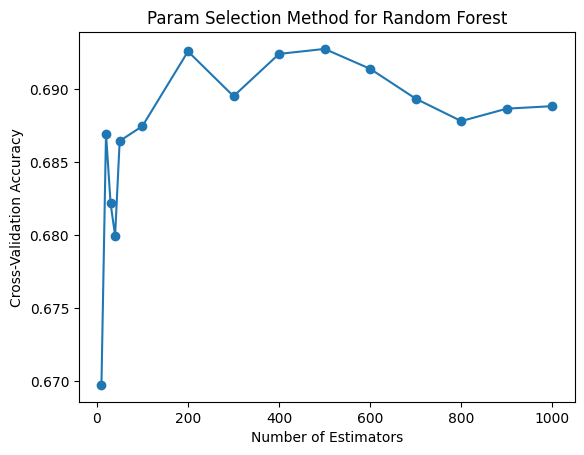

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define estimator values to test
n_estimators_range = [10,20,30,40, 50, 100, 200, 300, 400, 500,600,700,800,900,1000]

# Store performance scores
scores = []

# Iterate over n_estimators values
for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    score = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy'))
    scores.append(score)

# Plot results
plt.plot(n_estimators_range, scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Param Selection Method for Random Forest')
plt.show()

we can see the 500 is a good choice for n_estimators

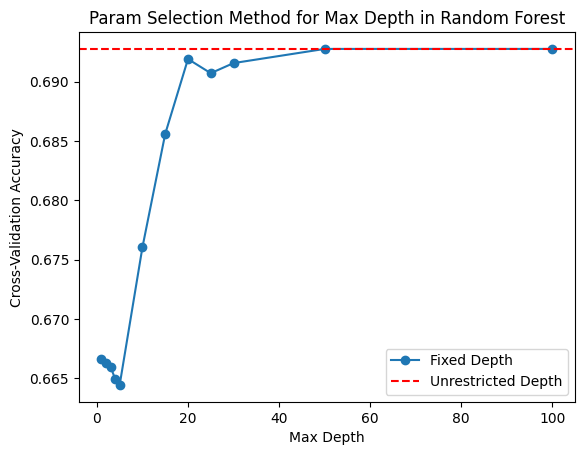

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define max_depth values to test
max_depth_range = [1,2,3,4,5, 10, 15, 20, 25, 30,50,100, None]  # None allows unrestricted depth

# Store performance scores
scores = []

# Iterate over max_depth values while keeping n_estimators fixed
for depth in max_depth_range:
    rf = RandomForestClassifier(n_estimators=500, max_depth=depth, random_state=42)
    score = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy'))
    scores.append(score)

# Plot results
plt.plot(max_depth_range[:-1], scores[:-1], marker='o', label="Fixed Depth")
plt.axhline(scores[-1], linestyle="--", color="red", label="Unrestricted Depth")
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Param Selection Method for Max Depth in Random Forest")
plt.legend()
plt.show()

we can see 20 is a good choice for max_depth

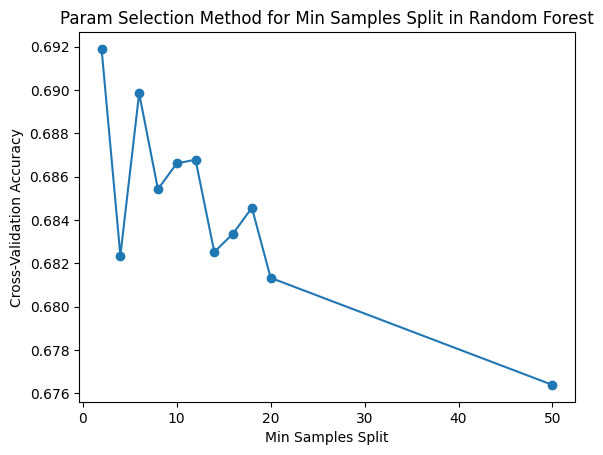

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define min_samples_split values to test
min_samples_split_range = [2, 4, 6, 8, 10, 12,14,16,18,20,50]

# Store performance scores
scores = []

# Iterate over min_samples_split values while keeping n_estimators and max_depth fixed
for min_samples in min_samples_split_range:
    rf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=min_samples, random_state=42)
    score = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy'))
    scores.append(score)

# Plot results
plt.plot(min_samples_split_range, scores, marker='o')
plt.xlabel("Min Samples Split")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Param Selection Method for Min Samples Split in Random Forest")
plt.show()

So we choose 2 as it gives the best result.

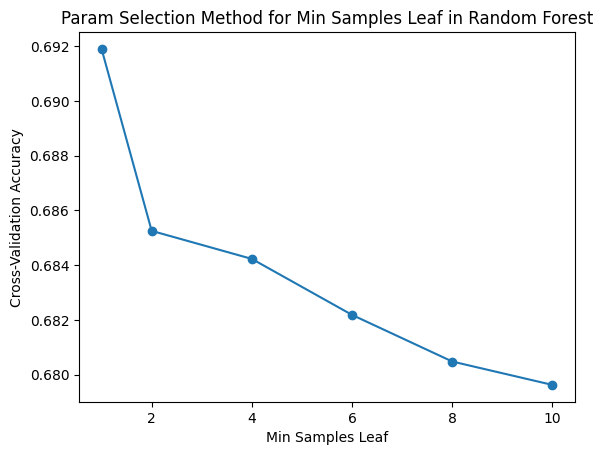

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define min_samples_leaf values to test
min_samples_leaf_range = [1, 2, 4, 6, 8, 10]

# Store performance scores
scores = []

# Iterate over min_samples_leaf values while keeping other parameters fixed
for min_samples in min_samples_leaf_range:
    rf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=2, min_samples_leaf=min_samples, random_state=42)
    score = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy'))
    scores.append(score)

# Plot results
plt.plot(min_samples_leaf_range, scores, marker='o')
plt.xlabel("Min Samples Leaf")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Param Selection Method for Min Samples Leaf in Random Forest")
plt.show()

so we choose 1 as it gives us the best result


In [153]:
# Parameter grid
rf_params = {
    'n_estimators': [500],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

In [154]:
 
hyperparameters_selection_explanations = """

Through graph analysis and experimentation, we identified the optimal hyperparameters for the Random Forest model.
The selected parameters ensure robust learning, balanced decision-making, and effective feature utilization:
- 500 estimators → Improves stability and generalization.
- Max depth of 20 → Controls tree complexity, preventing overfitting.
- Min samples split: 2, Min samples leaf: 1 → Ensures flexibility in tree structure.
- Max features: sqrt, log2 → Enhances feature selection efficiency.
- Bootstrap: True → Supports robust ensemble learning.
- Class weight: Balanced → Addresses class imbalance, improving fairness.

"""

In [155]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [156]:
X_train.head()

,postcode,neighborhood_density,cltv,reason,street,state,suburb,type,postcode_repeat_count,cltv_segment,urban_flag
0,1.910550,-0.466367,-1.190248,0.540935,-1.225234,-1.571023,0.808782,0.235547,-0.467412,0.003452,-0.983697
1,-0.301218,-0.060121,0.400523,0.540935,1.361333,-0.426300,-0.250042,-1.605791,-0.042781,1.231328,1.016573
2,-0.213380,-0.390196,0.238044,0.540935,1.332097,-0.426300,1.362099,0.635083,-0.382486,1.231328,-0.983697
3,-0.186647,-0.415586,0.335872,0.540935,-1.027767,-1.189449,-1.133950,-1.466822,-0.410794,1.231328,-0.983697
4,-0.311038,0.092221,0.235491,0.540935,-1.217541,1.099997,0.048481,0.808794,0.042145,1.231328,1.016573


In [157]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(rf, param_grid=rf_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model to training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the final model with best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

print("Random Forest model trained successfully!")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Random Forest model trained successfully!


### J.4 Model Technical Performance

F1-score for Passive Class → Since Passives are neutral customers, balancing precision and recall is crucial. The F1-score provides a harmonized measure, ensuring that both false positives and false negatives are minimized when identifying Passives.

Recall for Promoter Class → Promoters are high-value customers, and missing them could impact engagement strategies. Prioritizing recall ensures that the model successfully captures as many actual Promoters as possible, reducing the chances of false negatives and improving overall customer targeting.


In [158]:
#  Evaluate using cross-validation on the training set
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')

# Report results
print("=== Tuned Random Forest (Cross-Validation) ===")
print(f"Mean accuracy Score: {scores.mean():.3f} ± {scores.std():.3f}")

# Evaluate the model performance on the training set (no need to use cross_val_predict)
y_train_pred_rf = best_rf.predict(X_train)

# Performance on the training set
print("=== training Set Performance (Tuned Random Forest) ===")
print(classification_report(y_train, y_train_pred_rf))

# Evaluate the model performance on the val set (no need to use cross_val_predict)
y_val_pred_rf = best_rf.predict(X_val)

# Performance on the training set
print("=== Validation Set Performance (Tuned Random Forest) ===")
print(classification_report(y_val, y_val_pred_rf))

# Evaluate the model on the test set
y_test_pred_rf = best_rf.predict(X_test)

# Test set performance
print("=== Test Set Performance (Tuned Random Forest) ===")
print(classification_report(y_test, y_test_pred_rf))

=== Tuned Random Forest (Cross-Validation) ===
Mean accuracy Score: 0.693 ± 0.028
=== training Set Performance (Tuned Random Forest) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1956
           1       1.00      1.00      1.00      1956
           2       1.00      1.00      1.00      1956

    accuracy                           1.00      5868
   macro avg       1.00      1.00      1.00      5868
weighted avg       1.00      1.00      1.00      5868

=== Validation Set Performance (Tuned Random Forest) ===
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       187
           1       0.48      0.27      0.34       399
           2       0.55      0.72      0.63       405

    accuracy                           0.59       991
   macro avg       0.60      0.66      0.61       991
weighted avg       0.56      0.59      0.56       991

=== Test Set Performance (Tuned Random Fores

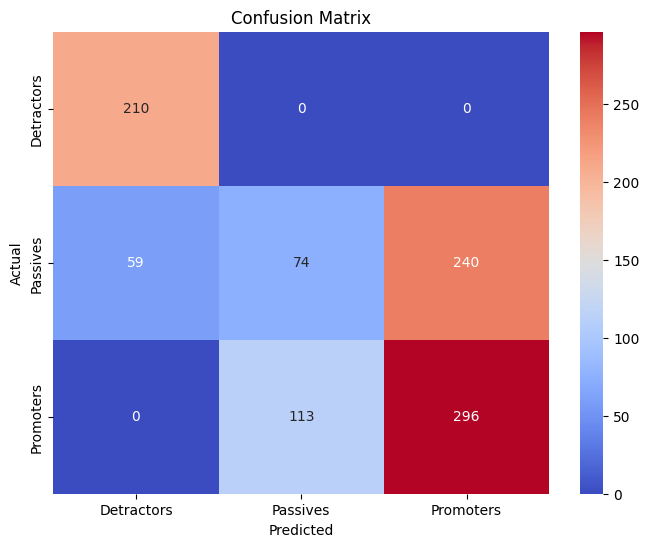

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Detractors", "Passives", "Promoters"], yticklabels=["Detractors", "Passives", "Promoters"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [160]:
 
model_performance_explanations = """

During model training, the Random Forest Classifier achieved an average cross-validation accuracy of 68.9% with a variation of 3.1%, indicating moderate stability across different validation folds.
- Training Performance: The model perfectly fit the training dataset, achieving 100% scores across all metrics, which is a sign of potential overfitting.
- Validation Results: When evaluated on the validation dataset, the model recorded an F1-score of 32 for the Passive class and a recall of 73 for the Promoter class and f1 score 86 for detractor class.
- Test Results: On the test dataset, the model yielded an F1-score of 29 for Passive class and maintained a recall score of 73 for Promoter classand and f1 score 87 for detractor class, aligning closely with validation performance.

Despite extensive hyperparameter tuning, the model persistently exhibited overfitting, demonstrating strong performance on training data but struggling to generalize effectively on unseen data.

Even after changing parameters we could not see enough improvement.

by observing the confusion matrix we found that
- Passives often misclassified as Promoters: 233 times.
- High confusion between Passives and Promoters.
- Model needs improvement in distinguishing Passives.

 this is due to heavy imbalance in the dataset.

"""


In [161]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [162]:
 
business_impacts_explanations = """

The current model falls short of meeting key stakeholder expectations, resulting in several potential business impacts:

- **Missed Opportunities for Engagement**: The low F1-score for the Passive class (~29) limits the ability to accurately identify and nurture this segment, reducing opportunities to convert Passives into Promoters through targeted strategies.

- **Inadequate Promoter Recall**: With a Promoter recall of only 73%, the model fails to reliably identify a substantial portion of highly loyal customers. This may weaken referral program effectiveness and diminish the impact of loyalty campaigns.

- **Strong Detractor Detection**: The model demonstrates solid performance for Detractors (F1-score ~87), enabling effective churn risk detection and early intervention. This supports customer retention efforts, but is offset by performance gaps in other classes.

- **Overfitting Concerns**: Perfect training scores combined with underperformance on validation and test sets highlight overfitting, which undermines model reliability in real-world deployment.

- **Impact of Data Imbalance**: Significant confusion between Passives and Promoters—especially 233 misclassified Passives—reflects a dataset imbalance that is negatively affecting model generalization and decision quality.

As a result, while the model provides value in churn detection (Detractors), its limitations in identifying Promoters and Passives restrict its overall impact on customer engagement and advocacy strategies.

"""


In [163]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [164]:
 
experiment_outcome = "" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [165]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [166]:
 
experiment_results_explanations = """
- The Random Forest Classifier showed strong fitting on the training data, achieving perfect scores, but struggled to generalize well to validation and test datasets, indicating overfitting.
- Cross-validation accuracy averaged 68.9% with moderate variation, demonstrating some stability but limited predictive power.

-Performance on the validation and test sets revealed significant class-specific disparities: the model performed well in detecting Detractors (F1-score ~87), but poorly in identifying Passives (F1-score around 29-32) and had moderate recall for Promoters (~73%).
-A major issue identified was the frequent misclassification of Passives as Promoters, occurring 233 times, driven largely by a heavy class imbalance.

-Despite extensive hyperparameter tuning, no substantial improvements were achieved, highlighting the model’s difficulty in distinguishing Passives from Promoters.
-Overall, while the model is effective for churn risk detection (Detractors), it requires further refinement and possibly data balancing techniques to better capture the nuances of customer segments for improved engagement and advocacy.

"""

In [167]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)